In [19]:
from google.colab import drive
drive.mount("/content/drive")

import os
import sys
import json
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report
)

PROJECT_DIR = "/content/drive/MyDrive/sepsis-timeline-project"
SRC_DIR = f"{PROJECT_DIR}/src"
os.chdir(PROJECT_DIR)

if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

print("✅ CWD:", os.getcwd())
print("✅ TF version:", tf.__version__)
print("✅ GPU:", tf.config.list_physical_devices("GPU"))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ CWD: /content/drive/MyDrive/sepsis-timeline-project
✅ TF version: 2.19.0
✅ GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# ============================================================
# 06_evaluation.ipynb
# ============================================================
# Syfte:
# - Ladda det preprocessade dev5000-datasetet (train/val/test)
# - Ladda sparade "bästa" modeller (LSTM/GRU/Transformer)
# - Utvärdera alla modeller på samma sätt (rättvis jämförelse)
#
# Alternativ A:
# - Skapa en jämförelsetabell med ROC-AUC, PR-AUC, F1, precision, recall
#
# Alternativ C:
# - Threshold-analys: hitta bästa tröskel på val (max F1)
# - Plotta F1/precision/recall mot threshold
# - Utvärdera test med vald tröskel
#
# Output:
# - Figurer sparas i outputs/figures/
# - Tabell sparas i outputs/tables/ (CSV)
# ============================================================


In [20]:
# =========================
# Konfig
# =========================
PROCESSED_NAME = "dev5000"  # <- vi jobbar på dev5000 nu
PROCESSED_DIR = os.path.join(PROJECT_DIR, "data", "processed", PROCESSED_NAME)

CKPT_DIR = os.path.join(PROJECT_DIR, "outputs", "checkpoints")
FIG_DIR  = os.path.join(PROJECT_DIR, "outputs", "figures")
TAB_DIR  = os.path.join(PROJECT_DIR, "outputs", "tables")

os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)

print("✅ PROCESSED_DIR:", PROCESSED_DIR)
print("✅ CKPT_DIR:", CKPT_DIR)
print("✅ FIG_DIR:", FIG_DIR)
print("✅ TAB_DIR:", TAB_DIR)


✅ PROCESSED_DIR: /content/drive/MyDrive/sepsis-timeline-project/data/processed/dev5000
✅ CKPT_DIR: /content/drive/MyDrive/sepsis-timeline-project/outputs/checkpoints
✅ FIG_DIR: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures
✅ TAB_DIR: /content/drive/MyDrive/sepsis-timeline-project/outputs/tables


In [21]:
## Hjälpfunktion: robust dataladdning från dev5000
def _try_load_npy(dirpath, candidates):
    """Försök ladda en .npy-fil från flera möjliga filnamn."""
    for name in candidates:
        fp = os.path.join(dirpath, name)
        if os.path.exists(fp):
            return np.load(fp, allow_pickle=False), fp
    return None, None

def load_processed_dataset(processed_dir):
    """
    Laddar train/val/test från processed_dir.
    Stödjer både .npy (separata filer) och .npz (samlat).
    """
    # 1) Om det finns en .npz (vanligt: dataset.npz)
    npz_candidates = ["dataset.npz", "data.npz", "processed.npz"]
    for npz_name in npz_candidates:
        npz_path = os.path.join(processed_dir, npz_name)
        if os.path.exists(npz_path):
            data = np.load(npz_path)
            keys = list(data.keys())
            print("✅ Hittade NPZ:", npz_path)
            print("   Keys:", keys)

            # Försök hitta rimliga keys
            def pick(*opts):
                for o in opts:
                    if o in data:
                        return data[o]
                return None

            train_X = pick("train_X", "X_train", "trainX")
            train_y = pick("train_y", "y_train", "trainy")
            val_X   = pick("val_X", "X_val", "valid_X", "X_valid")
            val_y   = pick("val_y", "y_val", "valid_y", "y_valid")
            test_X  = pick("test_X", "X_test", "testX")
            test_y  = pick("test_y", "y_test", "testy")

            if train_X is None:
                raise ValueError("Hittade NPZ men kunde inte matcha train_X osv. Kolla keys ovan.")

            return train_X, train_y, val_X, val_y, test_X, test_y

    # 2) Annars: ladda .npy (separata filer)
    train_X, fx = _try_load_npy(processed_dir, ["train_X.npy", "X_train.npy", "trainX.npy"])
    train_y, fy = _try_load_npy(processed_dir, ["train_y.npy", "y_train.npy", "trainy.npy"])

    val_X,   vx = _try_load_npy(processed_dir, ["val_X.npy", "X_val.npy", "valid_X.npy", "X_valid.npy"])
    val_y,   vy = _try_load_npy(processed_dir, ["val_y.npy", "y_val.npy", "valid_y.npy", "y_valid.npy"])

    test_X,  tx = _try_load_npy(processed_dir, ["test_X.npy", "X_test.npy", "testX.npy"])
    test_y,  ty = _try_load_npy(processed_dir, ["test_y.npy", "y_test.npy", "testy.npy"])

    if train_X is None or train_y is None or val_X is None or val_y is None or test_X is None or test_y is None:
        print("❌ Kunde inte hitta alla datasetfiler.")
        print("   Innehåll i mappen:")
        for f in sorted(os.listdir(processed_dir)):
            print("   -", f)
        raise FileNotFoundError("Saknar datasetfiler i processed-mappen (varken NPZ eller kompletta NPY).")

    print("✅ Hittade NPY-filer:")
    print("  train_X:", fx)
    print("  train_y:", fy)
    print("  val_X  :", vx)
    print("  val_y  :", vy)
    print("  test_X :", tx)
    print("  test_y :", ty)

    return train_X, train_y, val_X, val_y, test_X, test_y


In [22]:
## Ladda dataset + sanity check

train_X, train_y, val_X, val_y, test_X, test_y = load_processed_dataset(PROCESSED_DIR)

print("\n--- Shapes ---")
print("train_X:", train_X.shape, "train_y:", train_y.shape, "pos_rate:", float(train_y.mean()))
print("val_X  :", val_X.shape,   "val_y  :", val_y.shape,   "pos_rate:", float(val_y.mean()))
print("test_X :", test_X.shape,  "test_y :", test_y.shape,  "pos_rate:", float(test_y.mean()))

# Extra sanity: NaN?
print("\n--- NaN check ---")
print("train_X NaN:", np.isnan(train_X).any())
print("val_X   NaN:", np.isnan(val_X).any())
print("test_X  NaN:", np.isnan(test_X).any())


✅ Hittade NPY-filer:
  train_X: /content/drive/MyDrive/sepsis-timeline-project/data/processed/dev5000/train_X.npy
  train_y: /content/drive/MyDrive/sepsis-timeline-project/data/processed/dev5000/train_y.npy
  val_X  : /content/drive/MyDrive/sepsis-timeline-project/data/processed/dev5000/val_X.npy
  val_y  : /content/drive/MyDrive/sepsis-timeline-project/data/processed/dev5000/val_y.npy
  test_X : /content/drive/MyDrive/sepsis-timeline-project/data/processed/dev5000/test_X.npy
  test_y : /content/drive/MyDrive/sepsis-timeline-project/data/processed/dev5000/test_y.npy

--- Shapes ---
train_X: (12825, 48, 80) train_y: (12825,) pos_rate: 0.1352046783625731
val_X  : (2893, 48, 80) val_y  : (2893,) pos_rate: 0.11959903214656066
test_X : (2878, 48, 80) test_y : (2878,) pos_rate: 0.1296038915913829

--- NaN check ---
train_X NaN: False
val_X   NaN: False
test_X  NaN: False


In [23]:
## Bygg tf.data för val/test
BATCH_SIZE = 128

def make_ds(X, y, batch_size=128, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X.astype(np.float32), y.astype(np.float32)))
    if shuffle:
        ds = ds.shuffle(min(len(X), 20000), seed=42)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

val_ds  = make_ds(val_X, val_y, batch_size=BATCH_SIZE, shuffle=False)
test_ds = make_ds(test_X, test_y, batch_size=BATCH_SIZE, shuffle=False)

print("✅ Datasets klara:", val_ds, test_ds)


✅ Datasets klara: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 48, 80), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))> <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 48, 80), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


In [24]:
## Hitta & ladda modeller från checkpoints
def list_checkpoints(ckpt_dir):
    files = [f for f in os.listdir(ckpt_dir) if f.endswith(".keras")]
    return sorted(files)

ckpt_files = list_checkpoints(CKPT_DIR)
print("✅ Checkpoints i mappen:")
for f in ckpt_files:
    print(" -", f)

def pick_ckpt(patterns):
    """
    Returnerar första checkpointfil som matchar något av patterns (enkel contains-match).
    """
    for p in patterns:
        for f in ckpt_files:
            if p in f:
                return os.path.join(CKPT_DIR, f)
    return None

# Justera patterns om dina filnamn ser annorlunda ut
LSTM_BASELINE_PATH   = pick_ckpt(["best_lstm_baseline_dev5000", "lstm_baseline_dev5000"])
LSTM_IMPROVED_PATH   = pick_ckpt(["best_lstm_improved_dev5000", "lstm_improved_dev5000"])
GRU_BASELINE_PATH    = pick_ckpt(["best_gru_baseline_dev5000", "gru_baseline_dev5000"])
TRANSFORMER_BASELINE_PATH = pick_ckpt(["best_transformer_baseline_dev5000", "transformer_baseline_dev5000"])

print("\n--- Valda checkpoints ---")
print("LSTM baseline   :", LSTM_BASELINE_PATH)
print("LSTM improved   :", LSTM_IMPROVED_PATH)
print("GRU baseline    :", GRU_BASELINE_PATH)
print("Transformer base:", TRANSFORMER_BASELINE_PATH)


✅ Checkpoints i mappen:
 - best_gru_baseline.keras
 - best_gru_baseline_dev5000.keras
 - best_lstm_baseline.keras
 - best_lstm_baseline_dev5000.keras
 - best_lstm_improved.keras
 - best_lstm_improved_dev5000.keras
 - best_transformer_baseline_dev5000.keras

--- Valda checkpoints ---
LSTM baseline   : /content/drive/MyDrive/sepsis-timeline-project/outputs/checkpoints/best_lstm_baseline_dev5000.keras
LSTM improved   : /content/drive/MyDrive/sepsis-timeline-project/outputs/checkpoints/best_lstm_improved_dev5000.keras
GRU baseline    : /content/drive/MyDrive/sepsis-timeline-project/outputs/checkpoints/best_gru_baseline_dev5000.keras
Transformer base: /content/drive/MyDrive/sepsis-timeline-project/outputs/checkpoints/best_transformer_baseline_dev5000.keras


In [25]:
## Ladda modellerna
def load_model_safely(path):
    if path is None:
        return None
    print("📦 Laddar:", path)
    return tf.keras.models.load_model(path)

models = {
    "lstm_baseline": load_model_safely(LSTM_BASELINE_PATH),
    "lstm_improved": load_model_safely(LSTM_IMPROVED_PATH),
    "gru_baseline":  load_model_safely(GRU_BASELINE_PATH),
    "transformer_baseline": load_model_safely(TRANSFORMER_BASELINE_PATH),
}

# Ta bort None-modeller så vi inte kraschar senare
models = {k: v for k, v in models.items() if v is not None}

print("\n✅ Laddade modeller:", list(models.keys()))


📦 Laddar: /content/drive/MyDrive/sepsis-timeline-project/outputs/checkpoints/best_lstm_baseline_dev5000.keras
📦 Laddar: /content/drive/MyDrive/sepsis-timeline-project/outputs/checkpoints/best_lstm_improved_dev5000.keras


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'gmp' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


📦 Laddar: /content/drive/MyDrive/sepsis-timeline-project/outputs/checkpoints/best_gru_baseline_dev5000.keras
📦 Laddar: /content/drive/MyDrive/sepsis-timeline-project/outputs/checkpoints/best_transformer_baseline_dev5000.keras

✅ Laddade modeller: ['lstm_baseline', 'lstm_improved', 'gru_baseline', 'transformer_baseline']


In [26]:
## Prediktion helper + AUC/PR-AUC
def predict_probs(model, ds):
    probs = model.predict(ds, verbose=0).reshape(-1)
    return probs

def auc_metrics(y_true, probs):
    roc = roc_auc_score(y_true, probs)
    pr  = average_precision_score(y_true, probs)
    return float(roc), float(pr)


In [27]:
## Threshold sweep + bästa F1
def threshold_sweep(y_true, probs, thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(0.05, 0.95, 19)

    rows = []
    for thr in thresholds:
        y_pred = (probs >= thr).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        precision = tp / (tp + fp + 1e-12)
        recall    = tp / (tp + fn + 1e-12)
        f1        = 2 * precision * recall / (precision + recall + 1e-12)

        rows.append({
            "thr": float(thr),
            "precision": float(precision),
            "recall": float(recall),
            "f1": float(f1),
            "tp": int(tp), "fp": int(fp), "tn": int(tn), "fn": int(fn)
        })

    # bästa threshold = max F1
    best = max(rows, key=lambda r: r["f1"])
    return rows, best


In [28]:
## Plot: F1/Precision/Recall vs threshold + spara figur
def plot_threshold_curves(rows, title, out_path):
    thrs = [r["thr"] for r in rows]
    f1s  = [r["f1"] for r in rows]
    prs  = [r["precision"] for r in rows]
    rcs  = [r["recall"] for r in rows]

    plt.figure()
    plt.plot(thrs, f1s, label="F1")
    plt.plot(thrs, prs, label="Precision")
    plt.plot(thrs, rcs, label="Recall")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show()
    print("✅ Sparad:", out_path)



🔎 Modell: lstm_baseline
VAL  ROC-AUC=0.6637 | PR-AUC=0.2159
TEST ROC-AUC=0.5634 | PR-AUC=0.1602
⭐ Bästa threshold (VAL, max F1): 0.45 | F1=0.295
TEST @thr=0.45 => Precision=0.151, Recall=0.509, F1=0.233


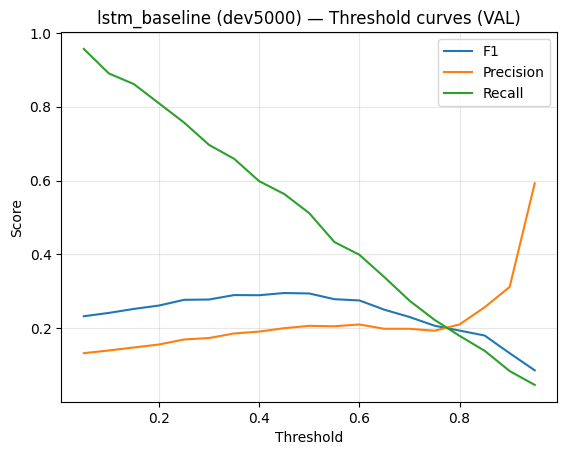

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/lstm_baseline_dev5000_threshold_curves.png

🔎 Modell: lstm_improved


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'gmp' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


VAL  ROC-AUC=0.6226 | PR-AUC=0.2412
TEST ROC-AUC=0.5805 | PR-AUC=0.1556
⭐ Bästa threshold (VAL, max F1): 0.55 | F1=0.252
TEST @thr=0.55 => Precision=0.149, Recall=0.233, F1=0.182


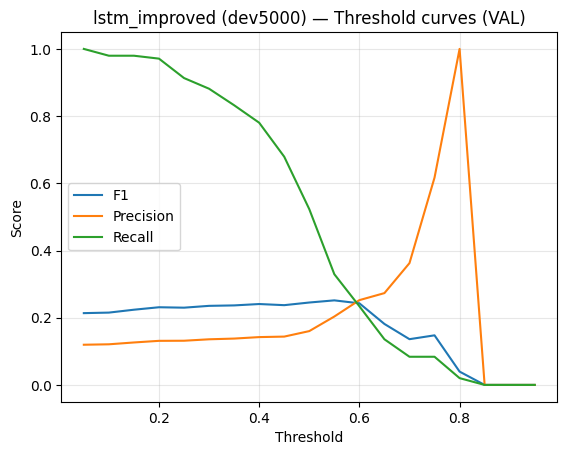

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/lstm_improved_dev5000_threshold_curves.png

🔎 Modell: gru_baseline
VAL  ROC-AUC=0.6479 | PR-AUC=0.1700
TEST ROC-AUC=0.5388 | PR-AUC=0.1587
⭐ Bästa threshold (VAL, max F1): 0.50 | F1=0.296
TEST @thr=0.50 => Precision=0.136, Recall=0.566, F1=0.219


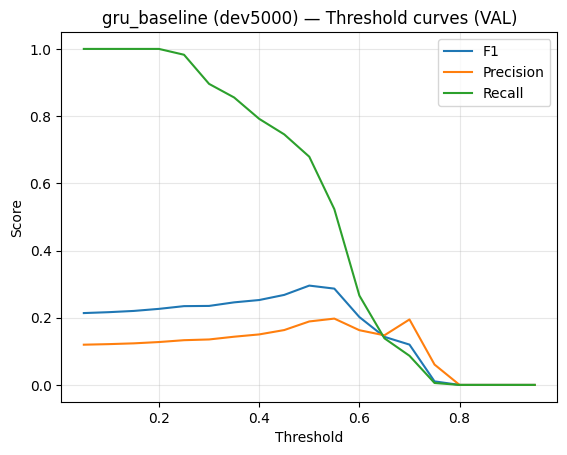

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/gru_baseline_dev5000_threshold_curves.png

🔎 Modell: transformer_baseline
VAL  ROC-AUC=0.6948 | PR-AUC=0.2606
TEST ROC-AUC=0.5493 | PR-AUC=0.1372
⭐ Bästa threshold (VAL, max F1): 0.80 | F1=0.365
TEST @thr=0.80 => Precision=0.152, Recall=0.298, F1=0.201


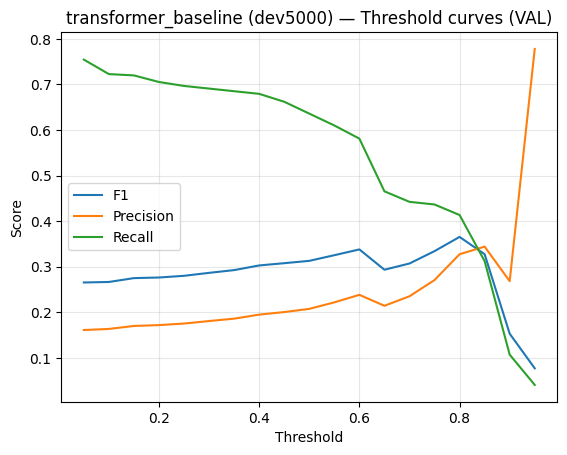

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/transformer_baseline_dev5000_threshold_curves.png

✅ Sparad jämförelsetabell: /content/drive/MyDrive/sepsis-timeline-project/outputs/tables/model_comparison_dev5000.csv


,model,processed,val_roc_auc,val_pr_auc,test_roc_auc,test_pr_auc,best_thr_val_f1,test_precision_at_bestthr,test_recall_at_bestthr,test_f1_at_bestthr,tp,fp,tn,fn,thr_fig
3,transformer_baseline,dev5000,0.694848,0.260609,0.549267,0.137246,0.80,0.152263,0.297587,0.201452,111,618,1887,262,transformer_baseline_dev5000_threshold_curves.png
1,lstm_improved,dev5000,0.622606,0.241184,0.580455,0.155645,0.55,0.148718,0.233244,0.181628,87,498,2007,286,lstm_improved_dev5000_threshold_curves.png
0,lstm_baseline,dev5000,0.663740,0.215868,0.563389,0.160228,0.45,0.151274,0.509383,0.233272,190,1066,1439,183,lstm_baseline_dev5000_threshold_curves.png
2,gru_baseline,dev5000,0.647925,0.169984,0.538800,0.158656,0.50,0.135517,0.565684,0.218653,211,1346,1159,162,gru_baseline_dev5000_threshold_curves.png


In [29]:
## Kör evaluation på alla modeller + spara CSV
results = []

for name, model in models.items():
    print("\n" + "="*60)
    print("🔎 Modell:", name)

    # Prediktioner
    val_probs  = predict_probs(model, val_ds)
    test_probs = predict_probs(model, test_ds)

    # AUC-mått
    val_roc,  val_pr  = auc_metrics(val_y,  val_probs)
    test_roc, test_pr = auc_metrics(test_y, test_probs)

    print(f"VAL  ROC-AUC={val_roc:.4f} | PR-AUC={val_pr:.4f}")
    print(f"TEST ROC-AUC={test_roc:.4f} | PR-AUC={test_pr:.4f}")

    # Threshold-analys på VAL (max F1)
    rows, best = threshold_sweep(val_y, val_probs)
    best_thr = best["thr"]
    best_f1  = best["f1"]

    print(f"⭐ Bästa threshold (VAL, max F1): {best_thr:.2f} | F1={best_f1:.3f}")

    # Utvärdera TEST vid den thresholden
    test_pred = (test_probs >= best_thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(test_y, test_pred).ravel()
    precision = tp / (tp + fp + 1e-12)
    recall    = tp / (tp + fn + 1e-12)
    f1        = 2 * precision * recall / (precision + recall + 1e-12)

    print(f"TEST @thr={best_thr:.2f} => Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")

    # Spara threshold-plot (Alternativ C)
    thr_fig = os.path.join(FIG_DIR, f"{name}_{PROCESSED_NAME}_threshold_curves.png")
    plot_threshold_curves(rows, f"{name} ({PROCESSED_NAME}) — Threshold curves (VAL)", thr_fig)

    results.append({
        "model": name,
        "processed": PROCESSED_NAME,
        "val_roc_auc": val_roc,
        "val_pr_auc": val_pr,
        "test_roc_auc": test_roc,
        "test_pr_auc": test_pr,
        "best_thr_val_f1": best_thr,
        "test_precision_at_bestthr": float(precision),
        "test_recall_at_bestthr": float(recall),
        "test_f1_at_bestthr": float(f1),
        "tp": int(tp), "fp": int(fp), "tn": int(tn), "fn": int(fn),
        "thr_fig": os.path.basename(thr_fig),
    })

# Spara tabell (Alternativ A)
import pandas as pd
df_res = pd.DataFrame(results).sort_values(by="val_pr_auc", ascending=False)

csv_path = os.path.join(TAB_DIR, f"model_comparison_{PROCESSED_NAME}.csv")
df_res.to_csv(csv_path, index=False)

print("\n✅ Sparad jämförelsetabell:", csv_path)
df_res


In [30]:
## Spara en kort JSON-sammanfattning för rapport
summary_path = os.path.join(TAB_DIR, f"model_comparison_{PROCESSED_NAME}.json")
with open(summary_path, "w") as f:
    json.dump(results, f, indent=2)

print("✅ Sparad JSON:", summary_path)


✅ Sparad JSON: /content/drive/MyDrive/sepsis-timeline-project/outputs/tables/model_comparison_dev5000.json


In [31]:
## Extra: visa “bästa modellen” enligt val PR-AUC
best_row = df_res.iloc[0]
print("🏆 Bästa modell enligt VAL PR-AUC:")
print(best_row[["model", "val_pr_auc", "val_roc_auc", "test_pr_auc", "test_roc_auc", "best_thr_val_f1", "test_f1_at_bestthr"]])


🏆 Bästa modell enligt VAL PR-AUC:
model                 transformer_baseline
val_pr_auc                        0.260609
val_roc_auc                       0.694848
test_pr_auc                       0.137246
test_roc_auc                      0.549267
best_thr_val_f1                        0.8
test_f1_at_bestthr                0.201452
Name: 3, dtype: object


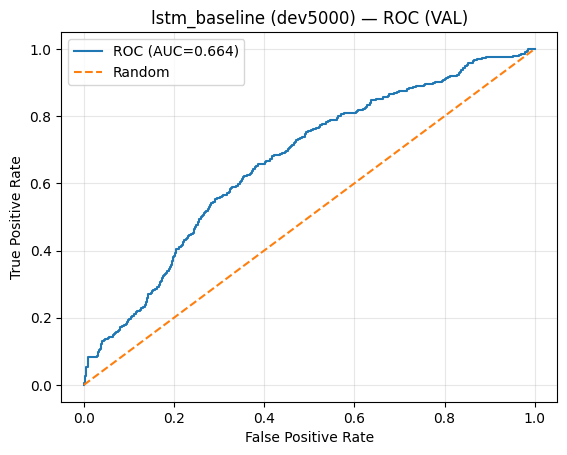

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/lstm_baseline_dev5000_roc_val.png


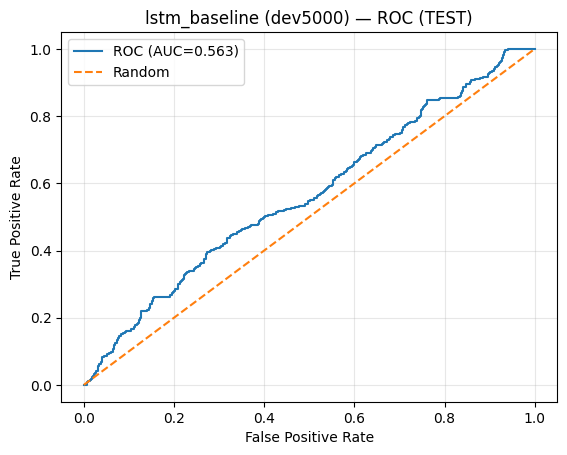

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/lstm_baseline_dev5000_roc_test.png


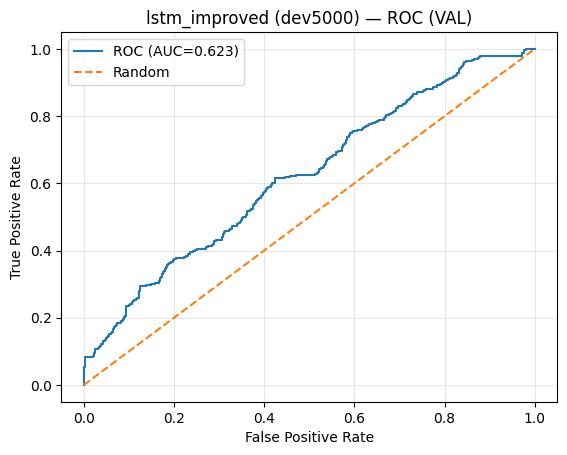

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/lstm_improved_dev5000_roc_val.png


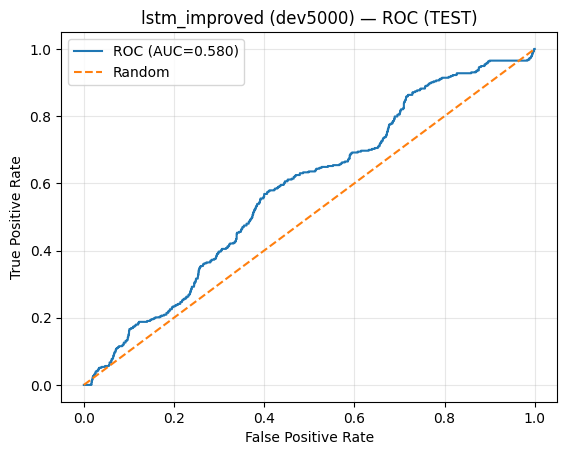

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/lstm_improved_dev5000_roc_test.png


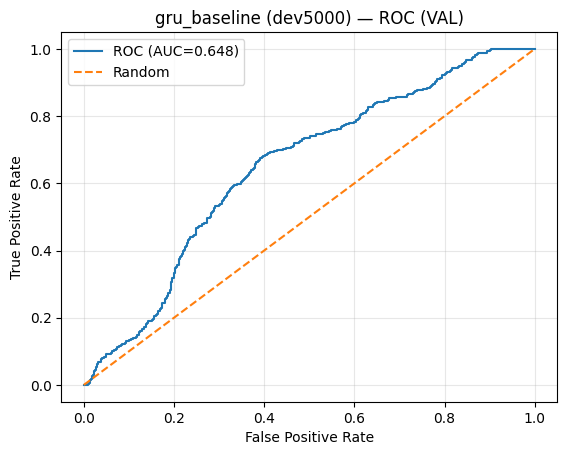

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/gru_baseline_dev5000_roc_val.png


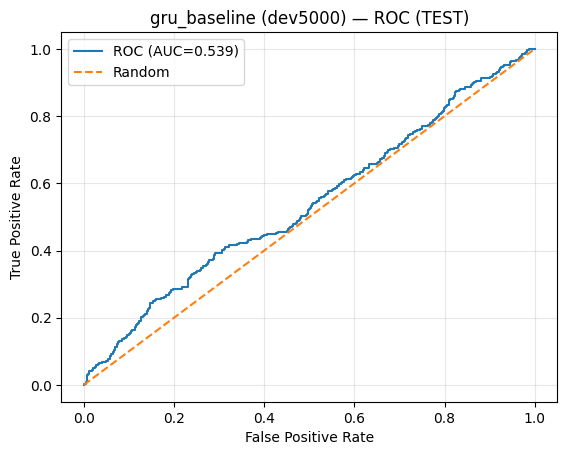

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/gru_baseline_dev5000_roc_test.png


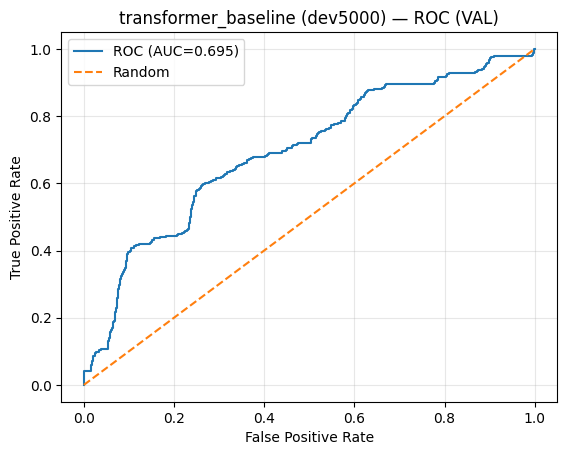

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/transformer_baseline_dev5000_roc_val.png


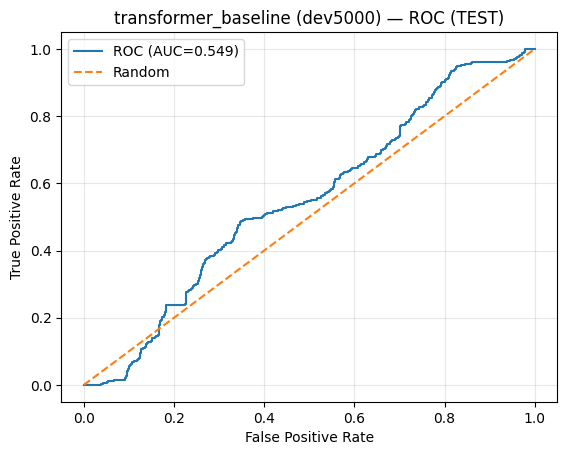

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/transformer_baseline_dev5000_roc_test.png


In [32]:
from sklearn.metrics import roc_curve, precision_recall_curve

## ROC-kurvor (VAL + TEST) för alla modeller
def plot_roc_curves(y_true, probs, title, out_path):
    fpr, tpr, _ = roc_curve(y_true, probs)
    auc = roc_auc_score(y_true, probs)

    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
    plt.plot([0, 1], [0, 1], "--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show()
    print("✅ Sparad:", out_path)

for name, model in models.items():
    # Prediktioner
    val_probs  = predict_probs(model, val_ds)
    test_probs = predict_probs(model, test_ds)

    out_val = os.path.join(FIG_DIR, f"{name}_{PROCESSED_NAME}_roc_val.png")
    out_test = os.path.join(FIG_DIR, f"{name}_{PROCESSED_NAME}_roc_test.png")

    plot_roc_curves(val_y, val_probs,  f"{name} ({PROCESSED_NAME}) — ROC (VAL)",  out_val)
    plot_roc_curves(test_y, test_probs, f"{name} ({PROCESSED_NAME}) — ROC (TEST)", out_test)



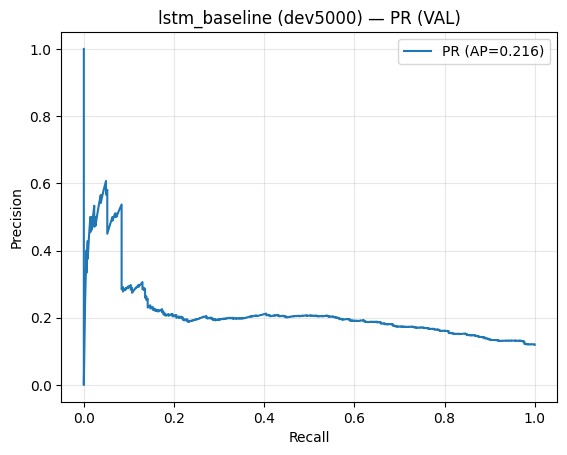

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/lstm_baseline_dev5000_pr_val.png


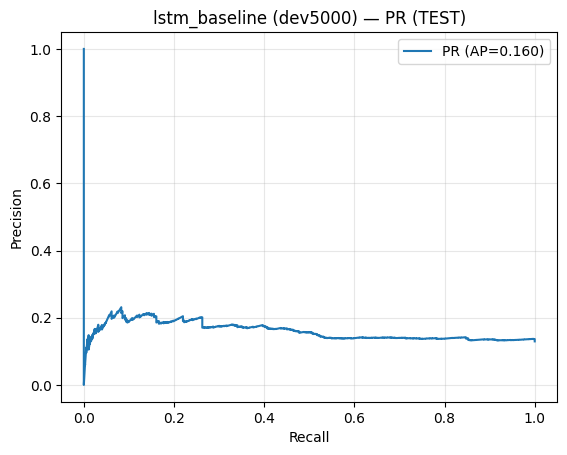

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/lstm_baseline_dev5000_pr_test.png


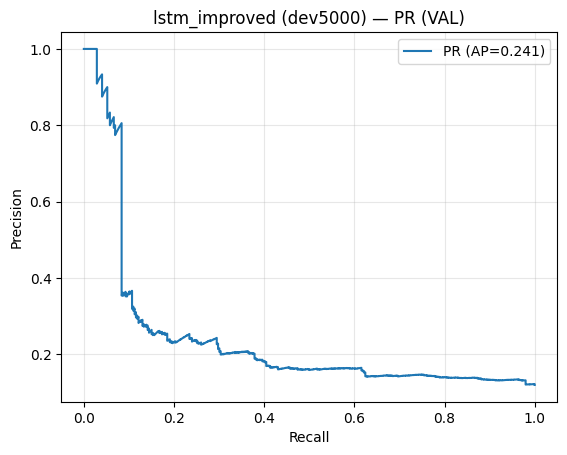

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/lstm_improved_dev5000_pr_val.png


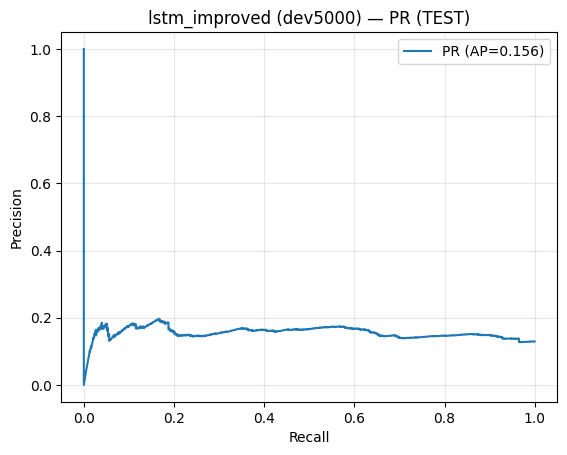

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/lstm_improved_dev5000_pr_test.png


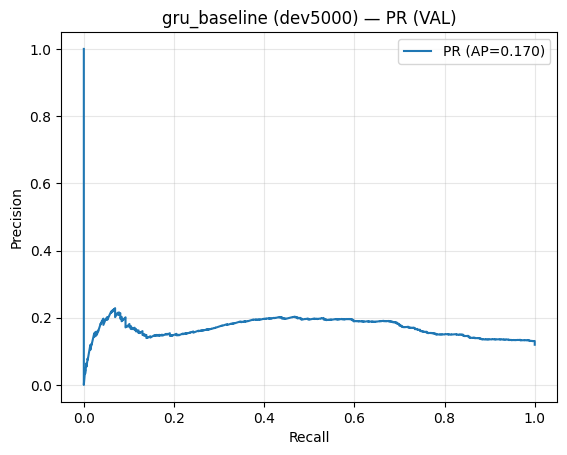

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/gru_baseline_dev5000_pr_val.png


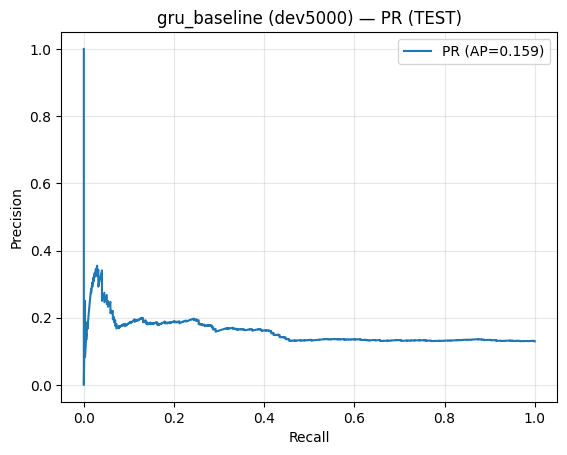

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/gru_baseline_dev5000_pr_test.png


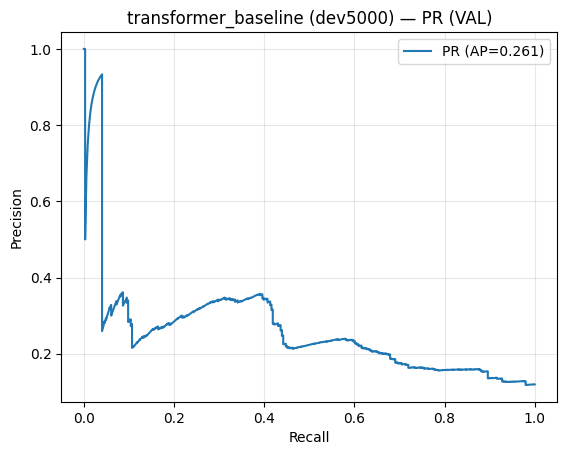

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/transformer_baseline_dev5000_pr_val.png


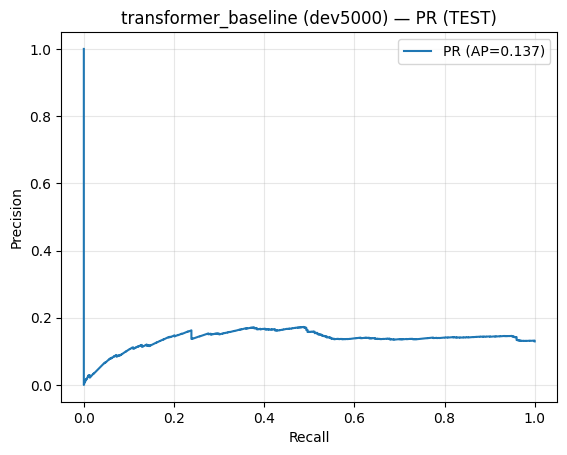

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/transformer_baseline_dev5000_pr_test.png


In [33]:
## PR-kurvor (VAL + TEST) för alla modeller
def plot_pr_curves(y_true, probs, title, out_path):
    precision, recall, _ = precision_recall_curve(y_true, probs)
    ap = average_precision_score(y_true, probs)

    plt.figure()
    plt.plot(recall, precision, label=f"PR (AP={ap:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show()
    print("✅ Sparad:", out_path)

for name, model in models.items():
    # Prediktioner
    val_probs  = predict_probs(model, val_ds)
    test_probs = predict_probs(model, test_ds)

    out_val = os.path.join(FIG_DIR, f"{name}_{PROCESSED_NAME}_pr_val.png")
    out_test = os.path.join(FIG_DIR, f"{name}_{PROCESSED_NAME}_pr_test.png")

    plot_pr_curves(val_y, val_probs,  f"{name} ({PROCESSED_NAME}) — PR (VAL)",  out_val)
    plot_pr_curves(test_y, test_probs, f"{name} ({PROCESSED_NAME}) — PR (TEST)", out_test)


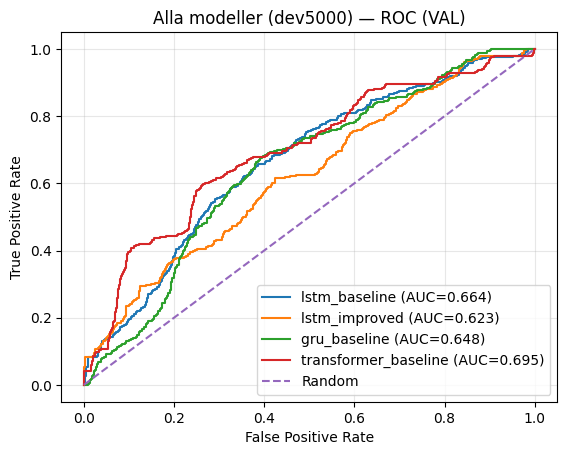

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/summary_dev5000_roc_val.png


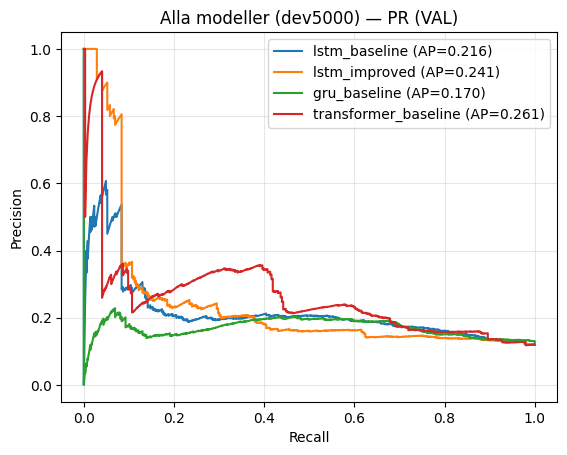

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/summary_dev5000_pr_val.png


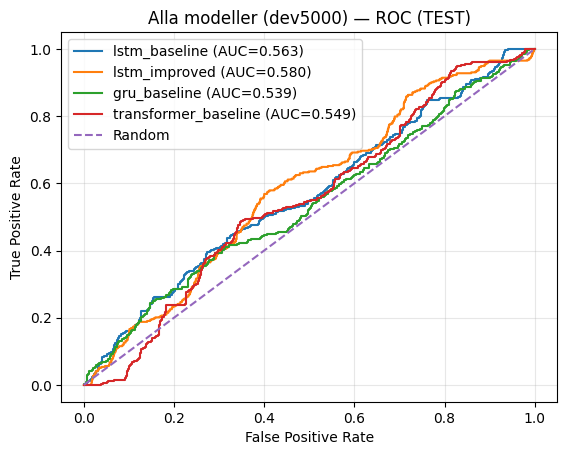

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/summary_dev5000_roc_test.png


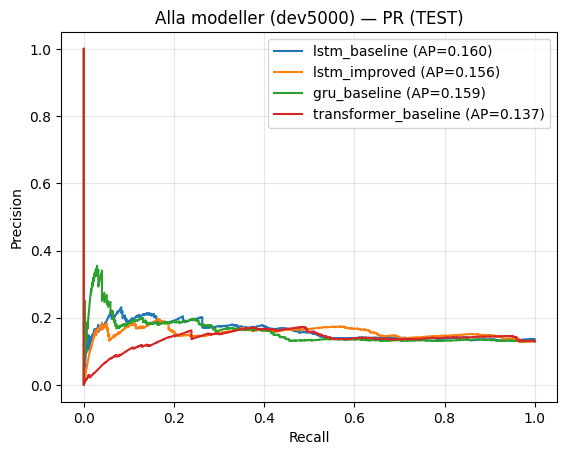

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/summary_dev5000_pr_test.png


In [34]:
## “Summary plots” (alla modeller i samma figur)

# ============================================================
# Cell 17 — Sammanfattningsfigurer (alla modeller i samma plot)
# ============================================================

def plot_roc_multi(models, ds, y_true, title, out_path):
    plt.figure()

    for name, model in models.items():
        probs = predict_probs(model, ds)
        fpr, tpr, _ = roc_curve(y_true, probs)
        auc = roc_auc_score(y_true, probs)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

    plt.plot([0, 1], [0, 1], "--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show()
    print("✅ Sparad:", out_path)


def plot_pr_multi(models, ds, y_true, title, out_path):
    plt.figure()

    for name, model in models.items():
        probs = predict_probs(model, ds)
        precision, recall, _ = precision_recall_curve(y_true, probs)
        ap = average_precision_score(y_true, probs)
        plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show()
    print("✅ Sparad:", out_path)


# ---- VAL sammanfattning ----
out_roc_val = os.path.join(FIG_DIR, f"summary_{PROCESSED_NAME}_roc_val.png")
out_pr_val  = os.path.join(FIG_DIR, f"summary_{PROCESSED_NAME}_pr_val.png")

plot_roc_multi(models, val_ds, val_y,
               title=f"Alla modeller ({PROCESSED_NAME}) — ROC (VAL)",
               out_path=out_roc_val)

plot_pr_multi(models, val_ds, val_y,
              title=f"Alla modeller ({PROCESSED_NAME}) — PR (VAL)",
              out_path=out_pr_val)


# ---- TEST sammanfattning ----
out_roc_test = os.path.join(FIG_DIR, f"summary_{PROCESSED_NAME}_roc_test.png")
out_pr_test  = os.path.join(FIG_DIR, f"summary_{PROCESSED_NAME}_pr_test.png")

plot_roc_multi(models, test_ds, test_y,
               title=f"Alla modeller ({PROCESSED_NAME}) — ROC (TEST)",
               out_path=out_roc_test)

plot_pr_multi(models, test_ds, test_y,
              title=f"Alla modeller ({PROCESSED_NAME}) — PR (TEST)",
              out_path=out_pr_test)


In [35]:
## Tabell med alla modeller + spara CSV

# ============================================================
# Cell 18 — Sammanfattningstabell (VAL + TEST) + spara CSV
# ============================================================

import pandas as pd
import numpy as np
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    confusion_matrix
)

def best_threshold_by_f1(y_true, probs, thresholds=None):
    """
    Hitta threshold som maximerar F1 på VAL.
    Vi loopar över thresholds och beräknar precision/recall/F1 manuellt.
    """
    if thresholds is None:
        thresholds = np.linspace(0.05, 0.95, 19)

    best_thr = 0.5
    best_f1 = -1.0
    best_prec, best_rec = 0.0, 0.0

    for thr in thresholds:
        y_pred = (probs >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        prec = tp / (tp + fp + 1e-12)
        rec  = tp / (tp + fn + 1e-12)
        f1   = 2 * prec * rec / (prec + rec + 1e-12)

        if f1 > best_f1:
            best_f1 = f1
            best_thr = float(thr)
            best_prec = float(prec)
            best_rec = float(rec)

    return best_thr, best_f1, best_prec, best_rec


def metrics_at_threshold(y_true, probs, thr):
    """Beräkna precision/recall/F1 + confusion matrix vid valt threshold."""
    y_pred = (probs >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    prec = tp / (tp + fp + 1e-12)
    rec  = tp / (tp + fn + 1e-12)
    f1   = 2 * prec * rec / (prec + rec + 1e-12)

    return float(prec), float(rec), float(f1), int(tn), int(fp), int(fn), int(tp)


rows = []

for name, model in models.items():
    # ---- Prediktioner (sannolikheter) ----
    val_probs  = predict_probs(model, val_ds)
    test_probs = predict_probs(model, test_ds)

    # ---- AUC-mått (threshold-oberoende) ----
    val_roc = roc_auc_score(val_y, val_probs)
    val_pr  = average_precision_score(val_y, val_probs)

    test_roc = roc_auc_score(test_y, test_probs)
    test_pr  = average_precision_score(test_y, test_probs)

    # ---- Bästa threshold på VAL (max F1) ----
    best_thr, best_f1_val, best_prec_val, best_rec_val = best_threshold_by_f1(val_y, val_probs)

    # ---- Test-mått vid samma threshold (fair jämförelse) ----
    test_prec, test_rec, test_f1, tn, fp, fn, tp = metrics_at_threshold(test_y, test_probs, best_thr)

    rows.append({
        "model": name,
        "val_roc_auc": val_roc,
        "val_pr_auc": val_pr,
        "best_thr_val": best_thr,
        "val_f1_at_best_thr": best_f1_val,
        "val_precision_at_best_thr": best_prec_val,
        "val_recall_at_best_thr": best_rec_val,

        "test_roc_auc": test_roc,
        "test_pr_auc": test_pr,
        "test_f1_at_val_thr": test_f1,
        "test_precision_at_val_thr": test_prec,
        "test_recall_at_val_thr": test_rec,

        "tn": tn, "fp": fp, "fn": fn, "tp": tp
    })

results_df = pd.DataFrame(rows)

# Sortera så "bäst" hamnar överst (du kan byta till val_pr_auc om du vill)
results_df = results_df.sort_values(by="val_pr_auc", ascending=False).reset_index(drop=True)

# Visa tabellen snyggt i notebooken
display(results_df)

# ---- Spara CSV ----
csv_path = os.path.join(FIG_DIR, f"summary_table_{PROCESSED_NAME}.csv")
results_df.to_csv(csv_path, index=False)
print("✅ Sparad CSV:", csv_path)


,model,val_roc_auc,val_pr_auc,best_thr_val,val_f1_at_best_thr,val_precision_at_best_thr,val_recall_at_best_thr,test_roc_auc,test_pr_auc,test_f1_at_val_thr,test_precision_at_val_thr,test_recall_at_val_thr,tn,fp,fn,tp
0,transformer_baseline,0.694848,0.260609,0.80,0.365262,0.327231,0.413295,0.549267,0.137246,0.201452,0.152263,0.297587,1887,618,262,111
1,lstm_improved,0.622606,0.241184,0.55,0.251656,0.203571,0.329480,0.580455,0.155645,0.181628,0.148718,0.233244,2007,498,286,87
2,lstm_baseline,0.663740,0.215868,0.45,0.295231,0.200000,0.563584,0.563389,0.160228,0.233272,0.151274,0.509383,1439,1066,183,190
3,gru_baseline,0.647925,0.169984,0.50,0.295597,0.188907,0.679191,0.538800,0.158656,0.218653,0.135517,0.565684,1159,1346,162,211


✅ Sparad CSV: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/summary_table_dev5000.csv


In [36]:
# ============================================================
# Exportera LaTeX-tabell för rapporten
# Skapar: outputs/logs/metrics_dev5000_table.tex
# ============================================================

import os

# Säkerställ loggmapp
LOG_DIR = os.path.join(PROJECT_DIR, "outputs", "logs")
os.makedirs(LOG_DIR, exist_ok=True)

latex_path = os.path.join(LOG_DIR, "metrics_dev5000_table.tex")

# Vi väljer och ordnar kolumner explicit (rent & kontrollerat)
cols = [
    "model",
    "val_roc_auc",
    "val_pr_auc",
    "test_roc_auc",
    "test_pr_auc",
    "best_thr_val",
    "test_precision_at_val_thr",
    "test_recall_at_val_thr",
    "test_f1_at_val_thr",
]

df_latex = results_df[cols].copy()

# Snyggare modellnamn för rapporten
name_map = {
    "lstm_baseline": "LSTM (baseline)",
    "lstm_improved": "LSTM (förbättrad)",
    "gru_baseline": "GRU (baseline)",
    "transformer_baseline": "Transformer"
}
df_latex["model"] = df_latex["model"].replace(name_map)

# Formatera numeriska värden
for c in df_latex.columns:
    if c != "model":
        df_latex[c] = df_latex[c].astype(float).map(lambda x: f"{x:.3f}")

# Bygg LaTeX-tabellen manuellt (för full kontroll)
latex_table = r"""
\begin{table}[H]
\centering
\caption{Sammanfattning av modellprestanda på dev5000.
Valideringsmått används för modellval, medan testmått rapporteras för generalisering.
PR-AUC är särskilt relevant vid klassobalans.}
\label{tab:metrics_dev5000}
\begin{tabular}{lcccccccc}
\toprule
\textbf{Modell} &
\textbf{Val ROC-AUC} &
\textbf{Val PR-AUC} &
\textbf{Test ROC-AUC} &
\textbf{Test PR-AUC} &
\textbf{Tröskel} &
\textbf{Prec.} &
\textbf{Recall} &
\textbf{F1} \\
\midrule
"""

for _, row in df_latex.iterrows():
    latex_table += (
        f"{row['model']} & "
        f"{row['val_roc_auc']} & "
        f"{row['val_pr_auc']} & "
        f"{row['test_roc_auc']} & "
        f"{row['test_pr_auc']} & "
        f"{row['best_thr_val']} & "
        f"{row['test_precision_at_val_thr']} & "
        f"{row['test_recall_at_val_thr']} & "
        f"{row['test_f1_at_val_thr']} \\\\\n"
    )

latex_table += r"""\bottomrule
\end{tabular}
\end{table}
"""

# Skriv till fil
with open(latex_path, "w", encoding="utf-8") as f:
    f.write(latex_table)

print("✅ LaTeX-tabell exporterad till:")
print(latex_path)


✅ LaTeX-tabell exporterad till:
/content/drive/MyDrive/sepsis-timeline-project/outputs/logs/metrics_dev5000_table.tex
